In [1]:
from vecstack import stacking
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
RANDOM_SEED = 42

os.environ['PYTHONHASHSEED']=str(RANDOM_SEED)

random.seed(RANDOM_SEED)

np.random.seed(RANDOM_SEED)

In [3]:
#métricas
modelos = []
acuracia = []
precisao = []
sensibilidade = []
especificidade = []
f1_score = []

In [4]:
def get_answers():
  for i in range(0, len(acuracia)):
    print("modelo: " + str(modelos[i]) + " possui acuracia de " + str(acuracia[i]))

In [5]:
#métricas de classificação
def metricas( list_pred, modelo):
  for i in range(0,len(list_pred)):
    cm = confusion_matrix(y_test, list_pred[i])

    acc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    prec = cm[1,1]/(cm[0,1]+cm[1,1])
    sens = cm[1,1]/(cm[1,0]+cm[1,1])
    esp=cm[0,0]/(cm[0,0]+cm[0,1])
    f1 = 2*prec*sens/(precisao+sensibilidade)

    modelos.append(modelo[i]), acuracia.append(acc), precisao.append(prec), sensibilidade.append(sens), especificidade.append(esp), f1_score.append(f1)

In [6]:
mitbih_train = pd.read_csv('mitbih_train.csv', header=None)
mitbih_test = pd.read_csv('mitbih_test.csv', header=None)



# Variáveis para treino
X_train = mitbih_train.iloc[:, :-1].values
y_train = mitbih_train.iloc[:, -1].values

# Variáveis para teste e validação (50% teste - 50% validação)
X_test, X_val, y_test, y_val = train_test_split(mitbih_test.iloc[:, :-1].values,
                                                mitbih_test.iloc[:, -1].values,
                                                test_size=0.5,
                                                random_state=RANDOM_SEED)

#X_test = mitbih_test.iloc[:, :-1].values
#y_test = mitbih_test.iloc[:, -1].values

In [7]:
# initializing all the base model objects with default parameters
model_1 = xgb.XGBClassifier(random_state=42)
model_2 = RandomForestClassifier(random_state=42)


# putting all base model objects in one list
all_models = [model_1, model_2]

# computing the stack features
s_train, s_test = stacking(all_models, X_train, y_train,  X_test, regression=False, n_folds=5, shuffle=True, verbose=2)

# initializing the second-level model
#model_stacking = LogisticRegression()
model_stacking = AdaBoostClassifier(random_state=42)

# fitting the second level model with stack features
model_stacking = model_stacking.fit(s_train, y_train)

# predicting the final output using stacking
ypred_stacking = model_stacking.predict(s_test)


list_pred = [ypred_stacking]
modelo = ['stacking']
metricas(list_pred, modelo)
get_answers()

task:         [classification]
n_classes:    [5]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [XGBClassifier]
    fold  0:  [0.97835646]
    fold  1:  [0.98121181]
    fold  2:  [0.98104049]
    fold  3:  [0.98035521]
    fold  4:  [0.98012564]
    ----
    MEAN:     [0.98021792] + [0.00101556]
    FULL:     [0.98021792]

model  1:     [RandomForestClassifier]
    fold  0:  [0.97236023]
    fold  1:  [0.97618640]
    fold  2:  [0.97493004]
    fold  3:  [0.97595797]
    fold  4:  [0.97595660]
    ----
    MEAN:     [0.97507825] + [0.00142709]
    FULL:     [0.97507824]



/opt/homebrew/anaconda3/envs/TCC/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


modelo: stacking possui acuracia de 0.9881631335413752


In [8]:
for model in all_models:
    model.fit(X_train, y_train)

s_val = np.column_stack([model.predict(X_val) for model in all_models])

y_val_pred = model_stacking.predict(s_val)
classification_report_val = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)

y_test_pred = model_stacking.predict(s_test)
classification_report_test = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)

print("Relatório de Classificação - Validação (Stacking)")
print(classification_report(y_val, y_val_pred, zero_division=0))

print("Relatório de Classificação - Teste (Stacking)")
print(classification_report(y_test, y_test_pred, zero_division=0))

cm_test = confusion_matrix(y_test, y_test_pred)
cm_val = confusion_matrix(y_val, y_val_pred)

specificities_test = []
for i in range(len(cm_test)):
    TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
    FP = np.sum(cm_test[:, i]) - cm_test[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_test.append(specificity)

specificity_mean_test = np.mean(specificities_test)
print(f"Especificidade Média do Stacking (Teste): {specificity_mean_test:.4f}")

specificities_val = []
for i in range(len(cm_val)):
    TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
    FP = np.sum(cm_val[:, i]) - cm_val[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_val.append(specificity)

specificity_mean_val = np.mean(specificities_val)
print(f"Especificidade Média do Stacking (Validação): {specificity_mean_val:.4f}")


Relatório de Classificação - Validação (Stacking)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9106
         1.0       0.95      0.71      0.81       267
         2.0       0.45      0.92      0.61       694
         3.0       0.85      0.67      0.75        84
         4.0       0.00      0.00      0.00       795

    accuracy                           0.91     10946
   macro avg       0.65      0.66      0.63     10946
weighted avg       0.87      0.91      0.89     10946

Relatório de Classificação - Teste (Stacking)
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9012
         1.0       0.94      0.64      0.77       289
         2.0       0.47      0.92      0.62       754
         3.0       0.89      0.79      0.84        78
         4.0       0.00      0.00      0.00       813

    accuracy                           0.91     10946
   macro avg       0.66      0.67  

In [12]:
from sklearn.metrics import confusion_matrix

print("Matriz de Confusão - Teste:")
print(cm_test)

print("\nMatriz de Confusão - Validação:")
print(cm_val)


Matriz de Confusão - Teste:
[[8997    9    5    1    0]
 [ 101  186    2    0    0]
 [  52    2  693    7    0]
 [  11    0    5   62    0]
 [  50    0  763    0    0]]

Matriz de Confusão - Validação:
[[9081   11   12    1    1]
 [  74  190    3    0    0]
 [  45    0  640    9    0]
 [  23    0    5   56    0]
 [  41    0  754    0    0]]


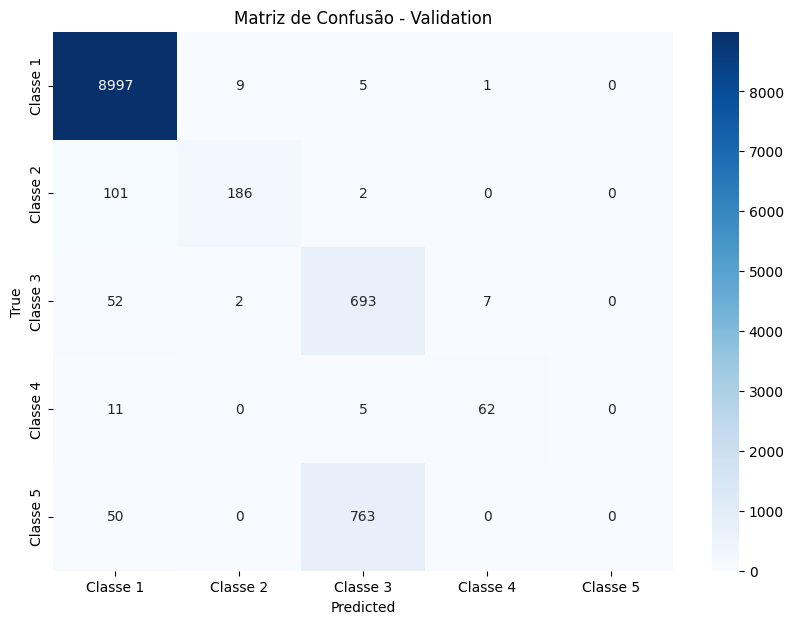

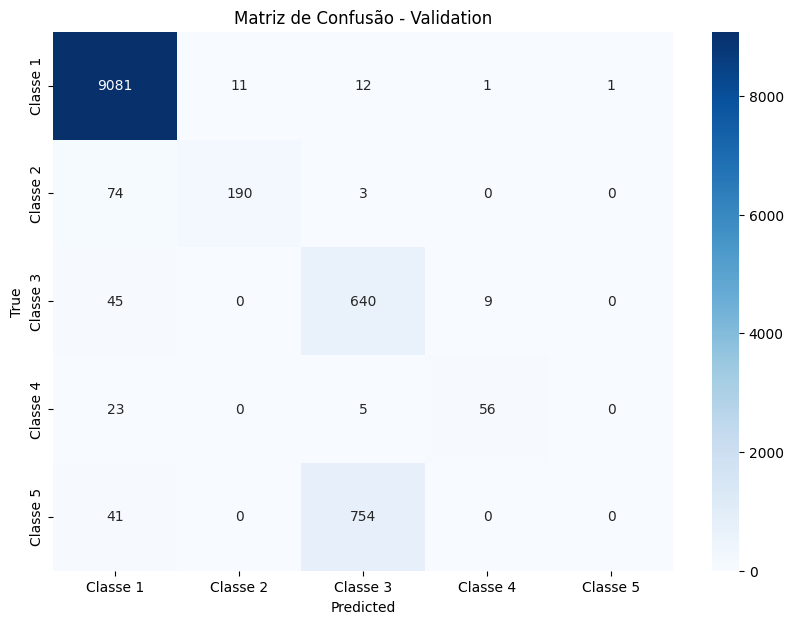

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'], yticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Matriz de Confusão - Validation')
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(cm_val, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'], yticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Matriz de Confusão - Validation')
plt.show()